In [50]:
pip install pybliometrics

Note: you may need to restart the kernel to use updated packages.


In [51]:
# library configuration: https://pybliometrics.readthedocs.io/en/latest/configuration.html
# The first time init() is run there will be a prompt to input the key and instoken
# API Key: 4fec016525bc7cf8febea7c81db45976
# Instoken: 03a9e22c2f85af0fcdd7f9415998446b


import pybliometrics

pybliometrics.scopus.init()


In [52]:
# Line of code to check where the configuration file is saved

pybliometrics.scopus.utils.constants.CONFIG_FILE

WindowsPath('C:/Users/FSzeliga/.config/pybliometrics.cfg')

In [1]:
# Import pacakages

from pybliometrics.scopus import ScopusSearch
from pybliometrics.scopus import AuthorSearch
import pandas as pd
import json
from tqdm import tqdm
import psycopg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import geopandas as gpd
import numpy as np
from wordcloud import WordCloud
from collections import Counter

In [54]:
# set of parameters

min_year = 2013
max_year = 2023

#### Applied Geography (APG)

In [55]:
# Query set up and Scopus search

apg_query = f'EXACTSRCTITLE(Applied+AND+Geography) AND PUBYEAR > {min_year-1} AND PUBYEAR < {max_year+1}' 

s1 = ScopusSearch(apg_query, verbose=True, download=True, refresh=180) # Refresh=180 means that the results will be downloaded again after 180 days (to ensure up-to-date information)


In [56]:
# Checking length of results

s1.get_results_size()

2193

In [57]:
# Conversion to dataframe

apg_df = pd.DataFrame(s1.results)

In [58]:
# Unique Values

unique_doi = apg_df['doi'].unique()
print(f"The total number of unique DOI values is {len(unique_doi)}")

unique_journal = apg_df['publicationName'].unique()
print(f"The total number of unique journal titles {len(unique_journal)}")

The total number of unique DOI values is 2193
The total number of unique journal titles 3


In [59]:
# Print Journal Unique Values
print(unique_journal)

['Applied Geography' 'Papers in Applied Geography'
 'The Black Sea from Paleogeography to Modern Navigation: Applied Maritime Geography and Oceanography']


In [60]:
# Filter the DataFrame to keep only rows where 'journal_title' is 'Applied Geography'
apg_df = apg_df[apg_df['publicationName'] == 'Applied Geography']

In [61]:
# Final length of df

len(apg_df)

1916

#### Cartography and Geographic Information Science (CaGIS)

In [62]:
# Query set up and Scopus search

cagis_query = f'EXACTSRCTITLE(Cartography+AND+Geographic+AND+Information+AND+Science) AND PUBYEAR > {min_year-1} AND PUBYEAR < {max_year+1}' 

s2 = ScopusSearch(cagis_query, verbose=True, download=True, refresh=180) # Refresh=180 means that the results will be downloaded again after 180 days (to ensure up-to-date information)

In [63]:
# Checking length of results

s2.get_results_size()

448

In [64]:
# Conversion to dataframe

cagis_df = pd.DataFrame(s2.results)

In [65]:
# Unique Values

unique_doi = cagis_df['doi'].unique()
print(f"The total number of unique DOI values is {len(unique_doi)}")

unique_journal = cagis_df['publicationName'].unique()
print(f"The total number of unique journal titles {len(unique_journal)}")

The total number of unique DOI values is 448
The total number of unique journal titles 1


In [66]:
# Print Journal Unique Values
print(unique_journal)

['Cartography and Geographic Information Science']


In [67]:
# Final length of df

len(cagis_df)

448

#### GIScience and Remote Sensing (G&RS)

In [68]:
# Query set up and Scopus search

gandrs_query = f'EXACTSRCTITLE(GIScience+AND+Remote+AND+Sensing) AND PUBYEAR > {min_year-1} AND PUBYEAR < {max_year+1}' 

s3 = ScopusSearch(gandrs_query, verbose=True, download=True, refresh=180) # Refresh=180 means that the results will be downloaded again after 180 days (to ensure up-to-date information)

In [69]:
# Checking length of results

s3.get_results_size()

700

In [70]:
# Conversion to dataframe

gandrs_df = pd.DataFrame(s3.results)

In [71]:
# Unique Values

unique_doi = gandrs_df['doi'].unique()
print(f"The total number of unique DOI values is {len(unique_doi)}")

unique_journal = gandrs_df['publicationName'].unique()
print(f"The total number of unique journal titles {len(unique_journal)}")

The total number of unique DOI values is 700
The total number of unique journal titles 2


In [72]:
# Print Journal Unique Values
print(unique_journal)

['GIScience and Remote Sensing'
 'Remote Sensing and GIScience: Challenges and Future Directions']


In [73]:
# Filter the DataFrame to keep only rows where 'journal_title' is 'GIScience and Remote Sensing'
gandrs_df = gandrs_df[gandrs_df['publicationName'] == 'GIScience and Remote Sensing']

In [74]:
# Final length of df

len(gandrs_df)

684

#### International Journal of Digital Earth (IJDE)

In [75]:
# Query set up and Scopus search

ijde_query = f'EXACTSRCTITLE(International+AND+Journal+AND+of+AND+Digital+AND+Earth) AND PUBYEAR > {min_year-1} AND PUBYEAR < {max_year+1}' 

s4 = ScopusSearch(ijde_query, verbose=True, refresh=180) # Refresh=180 means that the results will be downloaded again after 180 days (to ensure up-to-date information)

In [76]:
# Checking length of results

s4.get_results_size()

992

In [77]:
# Conversion to dataframe

ijde_df = pd.DataFrame(s4.results)

In [78]:
# Unique Values

unique_doi = ijde_df['doi'].unique()
print(f"The total number of unique DOI values is {len(unique_doi)}")

unique_journal = ijde_df['publicationName'].unique()
print(f"The total number of unique journal titles {len(unique_journal)}")

The total number of unique DOI values is 992
The total number of unique journal titles 1


In [79]:
# Print Journal Unique Values
print(unique_journal)

['International Journal of Digital Earth']


In [80]:
# Final length of df

len(ijde_df)

992

#### ISPRS International Journal of Geo-information (IJGI)

In [81]:
# Query set up and Scopus search

ijgi_query = f'EXACTSRCTITLE(ISPRS+AND+International+AND+Journal+AND+of+AND+Geo-information) AND PUBYEAR > {min_year-1} AND PUBYEAR < {max_year+1}' 

s5 = ScopusSearch(ijgi_query, verbose=True, refresh=180) # Refresh=180 means that the results will be downloaded again after 180 days (to ensure up-to-date information)

In [82]:
# Checking length of results

s5.get_results_size()

4690

In [83]:
# Conversion to dataframe

ijgi_df = pd.DataFrame(s5.results)

In [84]:
# Unique Values

unique_doi = ijgi_df['doi'].unique()
print(f"The total number of unique DOI values is {len(unique_doi)}")

unique_journal = ijgi_df['publicationName'].unique()
print(f"The total number of unique journal titles {len(unique_journal)}")

The total number of unique DOI values is 4690
The total number of unique journal titles 1


In [85]:
# Print Journal Unique Values
print(unique_journal)

['ISPRS International Journal of Geo-Information']


In [86]:
# Final length of df

len(ijgi_df)

4690

#### International Journal of Geographical Information Science (IJGIS)

In [87]:
# Query set up and Scopus search

ijgis_query = f'EXACTSRCTITLE(International+AND+Journal+AND+of+AND+Geographical+AND+Information+AND+Science) AND PUBYEAR > {min_year-1} AND PUBYEAR < {max_year+1}' 

s6 = ScopusSearch(ijgis_query, verbose=True, refresh=180) # Refresh=180 means that the results will be downloaded again after 180 days (to ensure up-to-date information)

In [88]:
# Checking length of results

s6.get_results_size()

1264

In [89]:
# Conversion to dataframe

ijgis_df = pd.DataFrame(s6.results)

In [90]:
# Unique Values

unique_doi = ijgis_df['doi'].unique()
print(f"The total number of unique DOI values is {len(unique_doi)}")

unique_journal = ijgis_df['publicationName'].unique()
print(f"The total number of unique journal titles {len(unique_journal)}")

The total number of unique DOI values is 1264
The total number of unique journal titles 1


In [91]:
# Print Journal Unique Values
print(unique_journal)

['International Journal of Geographical Information Science']


In [92]:
# Final length of df

len(ijgis_df)

1264

#### Journal of Spatial Science (JSS)

In [93]:
# Query set up and Scopus search

jss_query = f'EXACTSRCTITLE(Journal+AND+of+AND+Spatial+AND+Science) AND PUBYEAR > {min_year-1} AND PUBYEAR < {max_year+1}' 

s7 = ScopusSearch(jss_query, verbose=True, refresh=180) # Refresh=180 means that the results will be downloaded again after 180 days (to ensure up-to-date information)

In [94]:
# Checking length of results

s7.get_results_size()

493

In [95]:
# Conversion to dataframe

jss_df = pd.DataFrame(s7.results)

In [96]:
# Unique Values

unique_doi = jss_df['doi'].unique()
print(f"The total number of unique DOI values is {len(unique_doi)}")

unique_journal = jss_df['publicationName'].unique()
print(f"The total number of unique journal titles {len(unique_journal)}")

The total number of unique DOI values is 493
The total number of unique journal titles 2


In [97]:
# Print Journal Unique Values
print(unique_journal)

['Journal of Spatial Information Science' 'Journal of Spatial Science']


In [98]:
# Filter the DataFrame to keep only rows where 'journal_title' is 'Journal of Spatial Science'
jss_df = jss_df[jss_df['publicationName'] == 'Journal of Spatial Science']

In [99]:
# Final length of df

len(jss_df)

351

#### ISPRS Journal of Photogrammetry and Remote Sensing (P&RS)

In [100]:
# Query set up and Scopus search

pandrs_query = f'EXACTSRCTITLE(ISPRS+AND+Journal+AND+of+AND+Photogrammetry+AND+Remote+AND+Sensing) AND PUBYEAR > {min_year-1} AND PUBYEAR < {max_year+1}' 

s8 = ScopusSearch(pandrs_query, verbose=True, refresh=180) # Refresh=180 means that the results will be downloaded again after 180 days (to ensure up-to-date information)

In [101]:
# Checking length of results

s8.get_results_size()

2481

In [102]:
# Conversion to dataframe

pandrs_df = pd.DataFrame(s8.results)

In [103]:
# Unique Values

unique_doi = pandrs_df['doi'].unique()
print(f"The total number of unique DOI values is {len(unique_doi)}")

unique_journal = pandrs_df['publicationName'].unique()
print(f"The total number of unique journal titles {len(unique_journal)}")

The total number of unique DOI values is 2481
The total number of unique journal titles 2


In [104]:
# Print Journal Unique Values
print(unique_journal)

['ISPRS Open Journal of Photogrammetry and Remote Sensing'
 'ISPRS Journal of Photogrammetry and Remote Sensing']


In [105]:
# Filter the DataFrame to keep only rows where 'journal_title' is 'ISPRS Journal of Photogrammetry and Remote Sensing'
pandrs_df = pandrs_df[pandrs_df['publicationName'] == 'ISPRS Journal of Photogrammetry and Remote Sensing']

In [106]:
# Final length of df

len(pandrs_df)

2435

#### Transactions in GIS (TGIS)

In [107]:
# Query set up and Scopus search

tgis_query = f'EXACTSRCTITLE(Transactions+AND+in+AND+GIS) AND PUBYEAR > {min_year-1} AND PUBYEAR < {max_year+1}' 

s9 = ScopusSearch(tgis_query, verbose=True, refresh=180) # Refresh=180 means that the results will be downloaded again after 180 days (to ensure up-to-date information)

In [108]:
# Checking length of results

s9.get_results_size()

962

In [109]:
# Conversion to dataframe

tgis_df = pd.DataFrame(s9.results)

In [110]:
# Unique Values

unique_doi = tgis_df['doi'].unique()
print(f"The total number of unique DOI values is {len(unique_doi)}")

unique_journal = tgis_df['publicationName'].unique()
print(f"The total number of unique journal titles {len(unique_journal)}")

The total number of unique DOI values is 962
The total number of unique journal titles 1


In [111]:
# Print Journal Unique Values
print(unique_journal)

['Transactions in GIS']


In [112]:
# Final length of df

len(tgis_df)

962

#### ACM Transactions on Spatial Algorithms and Systems (TSAS)

In [113]:
# Query set up and Scopus search

tsas_query = f'EXACTSRCTITLE(ACM+AND+Transactions+AND+on+AND+Spatial+AND+Algorithms+AND+Systems) AND PUBYEAR > {min_year-1} AND PUBYEAR < {max_year+1}' 

s10 = ScopusSearch(tsas_query, verbose=True, refresh=180) # Refresh=180 means that the results will be downloaded again after 180 days (to ensure up-to-date information)

In [114]:
# Checking length of results

s10.get_results_size()

190

In [115]:
# Conversion to dataframe

tsas_df = pd.DataFrame(s10.results)

In [116]:
# Unique Values

unique_doi = tsas_df['doi'].unique()
print(f"The total number of unique DOI values is {len(unique_doi)}")

unique_journal = tsas_df['publicationName'].unique()
print(f"The total number of unique journal titles {len(unique_journal)}")

The total number of unique DOI values is 190
The total number of unique journal titles 1


In [117]:
# Print Journal Unique Values
print(unique_journal)

['ACM Transactions on Spatial Algorithms and Systems']


In [118]:
# Final length of df

len(tsas_df)

190

#### Combination of journal dataframes and export to json

In [119]:
# Concatenation of journals dataframes
scopus_api_df = pd.concat([apg_df, cagis_df, gandrs_df, ijde_df, ijgi_df, ijgis_df, jss_df, pandrs_df, tgis_df, tsas_df], ignore_index=True)
drop_columns = ['eid', 'pii', 'pubmed_id', 'subtype', 'afid', 'affilname','coverDisplayDate',
           'author_afids', 'source_id', 'eIssn', 'aggregationType','volume', 'description',
           'issueIdentifier', 'article_number', 'pageRange', 'citedby_count', 'openaccess', 'freetoread', 
           'freetoreadLabel', 'fund_acr', 'fund_no', 'fund_sponsor']

scopus_api_df = scopus_api_df.drop(columns = drop_columns)

In [120]:
# Drop rows where there is no creator data
scopus_api_df = scopus_api_df.dropna(subset=['creator'])

# First Author ID column
scopus_api_df['creator_id'] = scopus_api_df['author_ids'].apply(lambda x: x.split(';')[0] if pd.notna(x) else x)

# Replacing "creator" column value by full name of first author
scopus_api_df['creator'] = scopus_api_df['author_names'].apply(lambda x: x.split(';')[0])

# Split coverDate in month and year. 'coverDate' was used instead of 'coverDisplayDate' because it has a more standarised format.
scopus_api_df[['PubYear', 'PubMonth','PubDay']] = scopus_api_df['coverDate'].str.split('-', expand=True)
monthNames = {
'01' : 'January', '02' : 'February', '03' : 'March', '04' : 'April', '05' : 'May', '06' : 'June', '07' : 'July', '08' : 'August',
'09' : 'September', '10' : 'October', '11' : 'November', '12' : 'December'
 }

scopus_api_df['PubMonth'] = scopus_api_df['PubMonth'].map(monthNames)

# Drop coverDate column from df

scopus_api_df = scopus_api_df.drop('coverDate', axis= 1)

# Removing all publications that are not under the subtypeDescription 'Article' because these are the vast majority of results from APIs
scopus_api_df = scopus_api_df[scopus_api_df['subtypeDescription']=='Article']


The view of the data below shows that the API extracted multiple values for the columns "affiliation_city" and "affiliation_country", which refer to the first author of the article. Following further research on this issue using the Elsevier Search API - Interactive Documentation (https://dev.elsevier.com/search.html#!/Scopus_Search/ScopusSearch), it was noted that this seems to be a fault in the Scopus_Search API, because when searching for the author's details using the Author_Search API instead, only one affiliation name, city and country is returned in most cases for each author. 

In [121]:
# Overview of data
scopus_api_df.head(5)

,doi,title,subtypeDescription,creator,affiliation_city,affiliation_country,author_count,author_names,author_ids,publicationName,issn,authkeywords,creator_id,PubYear,PubMonth,PubDay
0,10.1016/j.apgeog.2023.103145,Trapped in dilemma: Inverted N-shaped EKC evid...,Article,"Huang, Jing",Beijing;Hong Kong,China;Hong Kong,6,"Huang, Jing;Zhang, Dong;Zhang, Zhengfeng;Kong,...",57382814800;57221284350;55774175000;5868965180...,Applied Geography,01436228,Ecological land | Economic growth | Inverted N...,57382814800,2023,December,01
1,10.1016/j.apgeog.2023.103136,Finding home: Participatory geospatial mapping...,Article,"Al-haddad, Robin Elizabeth",Ukhiya;Tucson,Bangladesh;United States,2,"Al-haddad, Robin Elizabeth;Rakshit, Pradipto V...",57220131060;57776198000,Applied Geography,01436228,Geo-positioning | Geographic oppression | Part...,57220131060,2023,December,01
2,10.1016/j.apgeog.2023.103122,Diffusion of the Internet-of-Things (IoT): A f...,Article,"Jamme, Huê Tâm",Tempe,United States,2,"Jamme, Huê Tâm;Connor, Dylan S.",57203571610;55215499600,Applied Geography,01436228,Community change | France | Internet of Things...,57203571610,2023,December,01
3,10.1016/j.apgeog.2023.103142,A multi-level framework for assessing the spat...,Article,"Dong, Junwu",Beijing,China,5,"Dong, Junwu;Wang, Yanhui;Yang, Yang;Luo, Xiaoy...",57565840500;56066264400;57225057111;5733714420...,Applied Geography,01436228,Accessibility | Public spaces | SDG 11.7.1 | S...,57565840500,2023,December,01
4,10.1016/j.apgeog.2023.103140,Urbanization shifts freshwater service flows i...,Article,"Shen, Wenting",Guangzhou,China,2,"Shen, Wenting;Liu, Zhenhuan",58675798400;55585649300,Applied Geography,01436228,Freshwater ecosystem service flow | Social-eco...,58675798400,2023,December,01


In [122]:
# Checking lenght of df

print("The total number of extracted articles is", len(scopus_api_df))

The total number of extracted articles is 12993


In [123]:
# Check for missing values in each column
print(scopus_api_df.isnull().sum())

doi                       0
title                     0
subtypeDescription        0
creator                   0
affiliation_city          5
affiliation_country       5
author_count              0
author_names              0
author_ids                0
publicationName           0
issn                   4452
authkeywords            963
creator_id                0
PubYear                   0
PubMonth                  0
PubDay                    0
dtype: int64


The results below show the number of rows with multiple values in the columns "affiliation_city" and " affiliation_country". 

In [124]:
# Checking for rows with more than one value in the specified columns
columns_to_check = ['affiliation_city', 'affiliation_country']

# Create a dictionary to store the count of rows with multiple values for each column
multiple_values_count = {}

# Iterate through the columns and count rows with more than one value
for column in columns_to_check:
    multiple_values_count[column] = scopus_api_df[scopus_api_df[column].str.contains(';', na=False)].shape[0]

# Display the counts
multiple_values_count

{'affiliation_city': 8646, 'affiliation_country': 8646}

The code below extracts details of the authors using the Author_Search API, searching by the first author ID number. The code then generates a new dataframe "affiliation_df". This dataframe and the original dataframe can then be merged with a left joint and the author's details can be replaced accordingly. 

In [125]:
# note: the default weekly quota for AuthorSearch is 5,000. Elsevier support extended it to 15,000 for my API key. 
# Initialise a list to store the extracted information
affiliation_details = []

# Unique creator_id values
unique_creator_ids = scopus_api_df['creator_id'].dropna().unique()

# Iterate through each author ID in the DataFrame
for author_id in tqdm(unique_creator_ids, desc="Processing authors"):
    try:
        # Perform the AuthorSearch
        search = AuthorSearch(f'AU-ID({author_id})', download=True, refresh=180)
        
        # Extract the required information if the author is found
        if search.authors:
            author_info = search.authors[0]  # There should be one match only
            affiliation_details.append({
                'author_id': author_id,
                'city': author_info.city,
                'country': author_info.country
            })
        else:
            affiliation_details.append({
                'author_id': author_id,
                'city': np.nan,
                'country': np.nan
            })
    except Exception as e:
        print(f"An error occurred while processing author ID {author_id}: {e}")

# Convert the list to a DataFrame
affiliation_df = pd.DataFrame(affiliation_details)

# Rename ID column
affiliation_df.rename(columns={'author_id': 'creator_id'}, inplace=True)



Processing authors: 100%|██████████| 10000/10000 [02:03<00:00, 81.21it/s]


In [126]:
affiliation_df.head(5)

,creator_id,city,country
0,57382814800,Beijing,China
1,57220131060,Tucson,United States
2,57203571610,Tempe,United States
3,57565840500,Beijing,China
4,58675798400,Guangzhou,China


Now there are no rows with multiple values in the columns "city" or "country".

In [127]:
# Checking for rows with more than one value in the specified columns
columns_to_check2 = ['city', 'country']

# Create a dictionary to store the count of rows with multiple values for each column
multiple_values_count2 = {}

# Iterate through the columns and count rows with more than one value
for column in columns_to_check2:
    multiple_values_count2[column] = affiliation_df[affiliation_df[column].str.contains(';', na=False)].shape[0]

# Display the counts
multiple_values_count2

{'city': 0, 'country': 0}

In [128]:
# Merge the two dataframes
scopus_api_df_copy = scopus_api_df.copy()
scopus_api_df = scopus_api_df_copy.merge(affiliation_df, on='creator_id', how='left')
scopus_api_df['affiliation_city'] = scopus_api_df['city']
scopus_api_df['affiliation_country'] = scopus_api_df['country']
scopus_api_df= scopus_api_df.drop(['city', 'country'], axis=1)

scopus_api_df.head(5)

,doi,title,subtypeDescription,creator,affiliation_city,affiliation_country,author_count,author_names,author_ids,publicationName,issn,authkeywords,creator_id,PubYear,PubMonth,PubDay
0,10.1016/j.apgeog.2023.103145,Trapped in dilemma: Inverted N-shaped EKC evid...,Article,"Huang, Jing",Beijing,China,6,"Huang, Jing;Zhang, Dong;Zhang, Zhengfeng;Kong,...",57382814800;57221284350;55774175000;5868965180...,Applied Geography,01436228,Ecological land | Economic growth | Inverted N...,57382814800,2023,December,01
1,10.1016/j.apgeog.2023.103136,Finding home: Participatory geospatial mapping...,Article,"Al-haddad, Robin Elizabeth",Tucson,United States,2,"Al-haddad, Robin Elizabeth;Rakshit, Pradipto V...",57220131060;57776198000,Applied Geography,01436228,Geo-positioning | Geographic oppression | Part...,57220131060,2023,December,01
2,10.1016/j.apgeog.2023.103122,Diffusion of the Internet-of-Things (IoT): A f...,Article,"Jamme, Huê Tâm",Tempe,United States,2,"Jamme, Huê Tâm;Connor, Dylan S.",57203571610;55215499600,Applied Geography,01436228,Community change | France | Internet of Things...,57203571610,2023,December,01
3,10.1016/j.apgeog.2023.103142,A multi-level framework for assessing the spat...,Article,"Dong, Junwu",Beijing,China,5,"Dong, Junwu;Wang, Yanhui;Yang, Yang;Luo, Xiaoy...",57565840500;56066264400;57225057111;5733714420...,Applied Geography,01436228,Accessibility | Public spaces | SDG 11.7.1 | S...,57565840500,2023,December,01
4,10.1016/j.apgeog.2023.103140,Urbanization shifts freshwater service flows i...,Article,"Shen, Wenting",Guangzhou,China,2,"Shen, Wenting;Liu, Zhenhuan",58675798400;55585649300,Applied Geography,01436228,Freshwater ecosystem service flow | Social-eco...,58675798400,2023,December,01


In [129]:
# Check for the number of rows missing the first author affiliation country
rows_with_none = scopus_api_df[scopus_api_df['affiliation_country'].isna()]

# Print the rows with None values in the 'country' column
#print(rows_with_none)

len(rows_with_none)


43

In [130]:
# Checking the length of the dataframe to ensure that it has not changed
len(scopus_api_df)

12993

Once the dataframes are joined and the data is replaced, there are no rows with multiple affiliation countries and cities.

In [131]:
# Checking for rows with more than one value in the specified columns
columns_to_check = ['affiliation_city', 'affiliation_country']

# Create a dictionary to store the count of rows with multiple values for each column
multiple_values_count = {}

# Iterate through the columns and count rows with more than one value
for column in columns_to_check:
    multiple_values_count[column] = scopus_api_df[scopus_api_df[column].str.contains(';', na=False)].shape[0]

# Display the counts
multiple_values_count

{'affiliation_city': 0, 'affiliation_country': 0}

In [132]:
# Export df to json file
scopus_api_df.to_json('scopus_api_top10.json', orient='records', lines=True)

#### Json file to Database

In [133]:
# Loading json file
jsonData = []
with open("scopus_api_top10.json","r") as file:
    for line in file:
        jsonData.append(json.loads(line))

In [135]:
## make the structure of your table 

tableName = "ScopusAPIData"
dropTable = "DROP TABLE IF EXISTS {} ;\n".format(tableName)

createTableStatement = "CREATE TABLE {} (\n".format(tableName)

createTableStatement = createTableStatement + "pkID SERIAL PRIMARY KEY NOT NULL,\n"
createTableStatement = createTableStatement + "DOI TEXT NOT NULL,\n"
createTableStatement = createTableStatement + "ISSN INTEGER,\n"
createTableStatement = createTableStatement + "Title TEXT NOT NULL,\n"
createTableStatement = createTableStatement + "Type TEXT NOT NULL,\n "
createTableStatement = createTableStatement + "First_Author TEXT NOT NULL,\n "
createTableStatement = createTableStatement + "First_Author_ID BIGINT NOT NULL,\n "
createTableStatement = createTableStatement + "Affil_City TEXT,\n "
createTableStatement = createTableStatement + "Affil_Country TEXT,\n "
createTableStatement = createTableStatement + "Author_Count INTEGER NOT NULL,\n"
createTableStatement = createTableStatement + "Author_Names TEXT NOT NULL,\n "
createTableStatement = createTableStatement + "Author_IDs TEXT NOT NULL,\n "
createTableStatement = createTableStatement + "Pub_Day INTEGER NOT NULL,\n "
createTableStatement = createTableStatement + "Pub_Month TEXT NOT NULL,\n "
createTableStatement = createTableStatement + "Pub_Year INTEGER NOT NULL,\n "
createTableStatement = createTableStatement + "Journal TEXT NOT NULL,\n "
createTableStatement = createTableStatement + "Keywords TEXT\n "
createTableStatement = createTableStatement  + ");\n"

outputSQLFile = open("ScopusAPIData.sql", "w")
outputSQLFile.write(dropTable)
outputSQLFile.write(createTableStatement)

#[{"DOI":"XX","ISSN":XX,"Title":"XX","Type":"XX","First_Author":"XX"},
for obj in tqdm(jsonData, desc="Processing objects"):
    DOI =  obj["doi"]
    ISSN = obj.get("issn", None)  # Handle missing ISSN
    Title = obj["title"].replace("'", "''")
    Type = obj["subtypeDescription"]
    First_Author =  obj["creator"].replace("'", "''")
    First_Author_ID = obj["creator_id"]
    Affil_City = obj["affiliation_city"].replace("'", "''") if obj["affiliation_city"] else None
    Affil_Country = obj["affiliation_country"].replace("'", "''") if obj["affiliation_country"] else None
    Author_Count = obj["author_count"]
    Author_Names = obj["author_names"].replace("'", "''")
    Author_IDs = obj["author_ids"]
    Pub_Day = obj["PubDay"]
    Pub_Month = obj["PubMonth"]
    Pub_Year = obj["PubYear"]
    Journal = obj["publicationName"].replace("'", "''")
    Keywords = obj["authkeywords"].replace("'", "''") if obj["authkeywords"] else None

    # Handle None values for optional fields
    ISSN_value = ISSN if ISSN else 'NULL'
    Affil_City_value = f"'{Affil_City}'" if Affil_City else 'NULL'
    Affil_Country_value = f"'{Affil_Country}'" if Affil_Country else 'NULL'
    Keywords_value = f"'{Keywords}'" if Keywords else 'NULL'

    
    insertStatement = f"""INSERT INTO {tableName} (DOI,ISSN,Title,Type,First_Author,First_Author_ID,Affil_City,Affil_Country,Author_Count,Author_Names,Author_IDs,Pub_Day,Pub_Month,Pub_Year,Journal,Keywords) VALUES ('{DOI}',{ISSN_value},'{Title}','{Type}','{First_Author}',{First_Author_ID},{Affil_City_value},{Affil_Country_value},{Author_Count},'{Author_Names}','{Author_IDs}','{Pub_Day}','{Pub_Month}','{Pub_Year}','{Journal}',{Keywords_value});
    """
    ## write each insert statement to the file

    outputSQLFile.write(insertStatement)

outputSQLFile.close() # close the output file so that it is written correctly. 

Processing objects: 100%|██████████| 12993/12993 [00:00<00:00, 38677.36it/s]


#### Querying the Database

In [2]:
# Postgres DB Connection params
dbHost = "localhost"
dbName = "postgres"
dbUser = "postgres"
dbPassword = "LaChiquitita_1011"

In [3]:
def ConnectToDatabase():
	try:
		conn = psycopg.connect( host=dbHost,dbname=dbName,user=dbUser,password=dbPassword)
		print ("Connected to database")
		return conn
	except:
		print("Database not found. Please enter correct database credentials in config.json")
		return None

In [4]:
# This shows how to run an SQL query with parameters. 
def sqlQuery(connection,query_text):
	try:
		cursor = connection.cursor()
		cursor.execute(query_text)
		results = cursor.fetchall()
		cursor.close()
		return results
	except psycopg.Error as error:
		print("Failed to execute query:", error)
		connection.rollback()


In [5]:
# Test query to check that the latest version of the database is being used

## Run an SQL query 
dbConnection = ConnectToDatabase()
Type = []
Count=[]
if dbConnection is not None:
    SQL_Query_Text = "SELECT Type, COUNT(*) as count from scopusapidata group by type"
    queryResults = sqlQuery(dbConnection,SQL_Query_Text)
    for s in queryResults:
        print("{}, {}".format(s[0], s[1]))
        Type.append(s[0])
        Count.append(s[1])
    print("\n")
    dbConnection.close()
else:
    print("Failed to connect to the database.")

Connected to database
Article, 12993




##### Number of Publications by Year

In [198]:
## Run an SQL query 
dbConnection = ConnectToDatabase()
Year = []
Count=[]
if dbConnection is not None:
    SQL_Query_Text = "select pub_year, count(*) from public.scopusapidata group by pub_year order by pub_year asc"
    queryResults = sqlQuery(dbConnection,SQL_Query_Text)
    for s in queryResults:
        print("Year = {}, Total publications = {}".format(s[0], s[1]))
        Year.append(s[0])
        Count.append(s[1])
    print("\n")
    dbConnection.close()
else:
    print("Failed to connect to the database.")

Connected to database
Year = 2013, Total publications = 676
Year = 2014, Total publications = 741
Year = 2015, Total publications = 827
Year = 2016, Total publications = 863
Year = 2017, Total publications = 1097
Year = 2018, Total publications = 1229
Year = 2019, Total publications = 1222
Year = 2020, Total publications = 1536
Year = 2021, Total publications = 1639
Year = 2022, Total publications = 1520
Year = 2023, Total publications = 1643




##### Top 10 Countries by Number of Publications

In [199]:
# Query to see the 10 countries with the most publications and percentage from total - 11 is used in query because NULL is in the top 10

## Run an SQL query 
dbConnection = ConnectToDatabase()
Country = []
Count=[]
tot_perc= []
if dbConnection is not None:
    SQL_Query_Text = "SELECT Affil_Country, COUNT(*) AS count, ROUND((COUNT(*)::float / total.total_count * 100)::numeric, 2) AS tot_percent FROM public.scopusapidata, (SELECT COUNT(*) AS total_count FROM public.scopusapidata) AS total where (Affil_Country is not null) GROUP BY Affil_Country, total.total_count ORDER BY count DESC limit 11"
    queryResults = sqlQuery(dbConnection,SQL_Query_Text)
    for s in queryResults:
        print("{}, Number of Publications = {} articles, % of Total = {}%".format(s[0], s[1], s[2]))
        Country.append(s[0])
        Count.append(s[1])
        tot_perc.append(s[2])
    print("\n")
    dbConnection.close()
else:
    print("Failed to connect to the database.")

Connected to database
China, Number of Publications = 4674 articles, % of Total = 35.97%
United States, Number of Publications = 1913 articles, % of Total = 14.72%
Germany, Number of Publications = 551 articles, % of Total = 4.24%
Spain, Number of Publications = 358 articles, % of Total = 2.76%
Canada, Number of Publications = 354 articles, % of Total = 2.72%
United Kingdom, Number of Publications = 350 articles, % of Total = 2.69%
Australia, Number of Publications = 332 articles, % of Total = 2.56%
Italy, Number of Publications = 329 articles, % of Total = 2.53%
Netherlands, Number of Publications = 228 articles, % of Total = 1.75%
South Korea, Number of Publications = 212 articles, % of Total = 1.63%
France, Number of Publications = 200 articles, % of Total = 1.54%




Text(0.5, 1.0, 'Top 10 Countries by Number of Publications between 2013-2023')

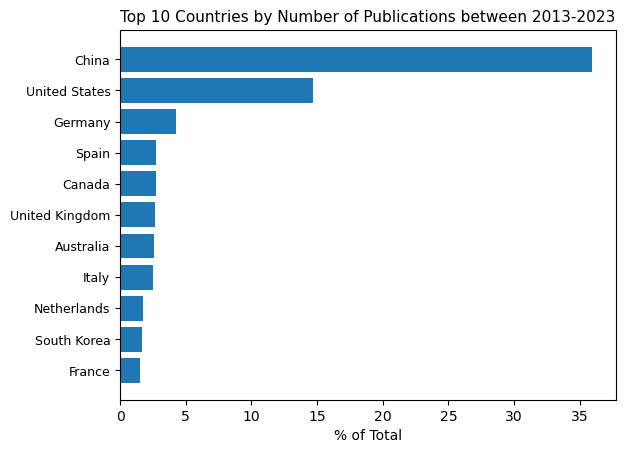

In [200]:
# Plotting results from query above 
fig, ax = plt.subplots()

y_pos = np.arange(len(Country))

ax.barh(y_pos, tot_perc, align='center')
ax.set_yticks(y_pos, labels=Country, fontsize = 9)
# Add annotation to bars
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% of Total', fontsize = 10)
ax.set_title('Top 10 Countries by Number of Publications between 2013-2023', fontsize = 11)

##### Top 10 Countries by Number of Publications per Journal

In [201]:
# Query to see the 10 countries with the most publications and percentage from total - 11 is used in query because NULL is in the top 10

## Run an SQL query 
dbConnection = ConnectToDatabase()
Journal = []
Country=[]
Count= []
if dbConnection is not None:
    SQL_Query_Text = "WITH ranked_country_bynopub AS (SELECT journal, Affil_Country, COUNT(*) AS count, ROW_NUMBER() OVER (PARTITION BY journal ORDER BY COUNT(*) DESC) AS rank FROM public.scopusapidata GROUP BY journal, Affil_Country) SELECT journal, Affil_Country, count FROM ranked_country_bynopub WHERE rank <= 10 ORDER BY journal,count DESC"
    queryResults = sqlQuery(dbConnection,SQL_Query_Text)
    for s in queryResults:
        print("{}, Country = {} articles, Total No. Publications = {}".format(s[0], s[1], s[2]))
        Journal.append(s[0])
        Country.append(s[1])
        Count.append(s[2])
    print("\n")
    dbConnection.close()
else:
    print("Failed to connect to the database.")

Connected to database
ACM Transactions on Spatial Algorithms and Systems, Country = United States articles, Total No. Publications = 62
ACM Transactions on Spatial Algorithms and Systems, Country = Australia articles, Total No. Publications = 11
ACM Transactions on Spatial Algorithms and Systems, Country = China articles, Total No. Publications = 10
ACM Transactions on Spatial Algorithms and Systems, Country = Japan articles, Total No. Publications = 10
ACM Transactions on Spatial Algorithms and Systems, Country = Germany articles, Total No. Publications = 10
ACM Transactions on Spatial Algorithms and Systems, Country = India articles, Total No. Publications = 8
ACM Transactions on Spatial Algorithms and Systems, Country = Greece articles, Total No. Publications = 6
ACM Transactions on Spatial Algorithms and Systems, Country = Canada articles, Total No. Publications = 6
ACM Transactions on Spatial Algorithms and Systems, Country = Denmark articles, Total No. Publications = 5
ACM Transa

##### Q1 - Publication Trend in China

In [202]:
# Number of publications by year from China - NOTE: these numbers exclude Hong Kong.

## Run an SQL query 
dbConnection = ConnectToDatabase()
Year = []
Count_China=[]
if dbConnection is not None:
    SQL_Query_Text = "select Pub_Year, count(*) as count from public.scopusapidata where (affil_country = 'China') group by Pub_Year order by Pub_Year asc"
    queryResults = sqlQuery(dbConnection,SQL_Query_Text)
    for s in queryResults:
        print("Year = {}, Number of Publications = {} articles".format(s[0], s[1]))
        Year.append(s[0])
        Count_China.append(s[1])
    print("\n")
    dbConnection.close()
else:
    print("Failed to connect to the database.")

Connected to database
Year = 2013, Number of Publications = 118 articles
Year = 2014, Number of Publications = 128 articles
Year = 2015, Number of Publications = 165 articles
Year = 2016, Number of Publications = 270 articles
Year = 2017, Number of Publications = 388 articles
Year = 2018, Number of Publications = 405 articles
Year = 2019, Number of Publications = 427 articles
Year = 2020, Number of Publications = 530 articles
Year = 2021, Number of Publications = 625 articles
Year = 2022, Number of Publications = 746 articles
Year = 2023, Number of Publications = 872 articles




Text(0.5, 0, 'Year')

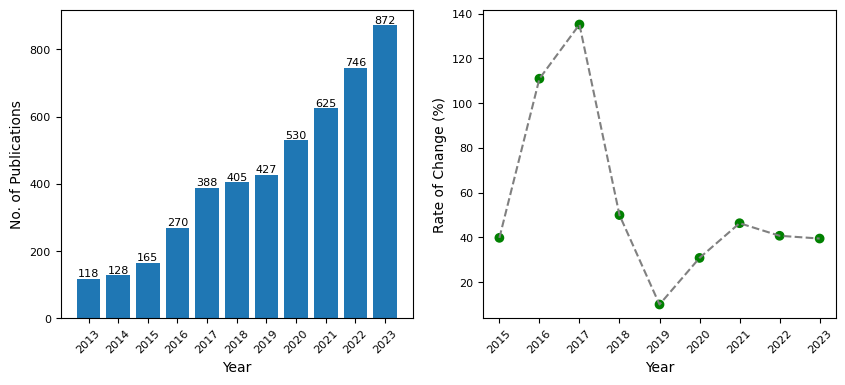

In [203]:
# PLOT - Number of publications by year from China

# dictionary of lists 
dict_China = {'Pub_Year': Year, 'Count': Count_China} 

# Create df from SQL query results
Pub_China = pd.DataFrame(dict_China)

# New column: rate of change in number of publications by year
Pub_China['Rate_of_Change'] = Pub_China['Count'].pct_change(periods=2) * 100

# Copy of df to exlude year 2013 as rate of change is NaN
Pub_China_exclnan = Pub_China[~Pub_China['Pub_Year'].isin([2013, 2014])] # ~ is the NOT operator

# Set up colour values for rate of change
colours = ['green' if val > 0 else 'yellow' if val == 0 else 'red' for val in Pub_China_exclnan['Rate_of_Change']]

# Plot number of publications and rate of change

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))

bars = ax1.bar(Pub_China['Pub_Year'], Pub_China['Count'], label=Pub_China['Pub_Year'])
ax1.set_xticks(Pub_China['Pub_Year'], labels=Pub_China['Pub_Year'], rotation= 45, size = 8)
ax1.tick_params(axis='y', labelsize=8)  # Set the label size for y-axis
ax1.set_ylabel('No. of Publications')
ax1.set_xlabel('Year', fontsize = 10)
#ax1.set_title('Number of Publications from China by Year', fontsize = 9)
# Add count value on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=8)


ax2.plot(Pub_China_exclnan['Pub_Year'], Pub_China_exclnan['Rate_of_Change'], linestyle="--", color= 'gray', label="Rate of Change")
ax2.scatter(Pub_China_exclnan['Pub_Year'], Pub_China_exclnan['Rate_of_Change'], color= colours)
ax2.set_xticks(Pub_China_exclnan['Pub_Year'], labels=Pub_China_exclnan['Pub_Year'], rotation= 45, size = 8)
ax2.tick_params(axis='y', labelsize=8)  # Set the label size for y-axis
#ax2.set_title('Two-Year Rate of Change in Number of Publications from China', fontsize = 9)
ax2.set_ylabel('Rate of Change (%)')
ax2.set_xlabel('Year', fontsize = 10)

In [204]:
# Number of publications by year from China by City - Top 3

## Run an SQL query 
dbConnection = ConnectToDatabase()
Year = []
City = []
Count_China_City=[]
if dbConnection is not None:
    SQL_Query_Text = "WITH ranked_cities AS (SELECT Pub_Year, Affil_City, COUNT(*) AS count, ROW_NUMBER() OVER (PARTITION BY Pub_Year ORDER BY COUNT(*) DESC) AS rank FROM public.scopusapidata WHERE affil_country = 'China' GROUP BY Pub_Year, Affil_City) SELECT Pub_Year, Affil_City, count FROM ranked_cities WHERE rank <= 3 ORDER BY Pub_Year, count DESC;"
    queryResults = sqlQuery(dbConnection,SQL_Query_Text)
    for s in queryResults:
        print("Year = {}, City = {}, No. Publications = {} articles".format(s[0], s[1], s[2]))
        Year.append(s[0])
        City.append(s[1])
        Count_China_City.append(s[2])
    print("\n")
    dbConnection.close()
else:
    print("Failed to connect to the database.")

Connected to database
Year = 2013, City = Beijing, No. Publications = 36 articles
Year = 2013, City = Wuhan, No. Publications = 24 articles
Year = 2013, City = Nanjing, No. Publications = 11 articles
Year = 2014, City = Beijing, No. Publications = 30 articles
Year = 2014, City = Wuhan, No. Publications = 24 articles
Year = 2014, City = Nanjing, No. Publications = 11 articles
Year = 2015, City = Beijing, No. Publications = 49 articles
Year = 2015, City = Wuhan, No. Publications = 36 articles
Year = 2015, City = Nanjing, No. Publications = 15 articles
Year = 2016, City = Beijing, No. Publications = 70 articles
Year = 2016, City = Wuhan, No. Publications = 67 articles
Year = 2016, City = Nanjing, No. Publications = 25 articles
Year = 2017, City = Wuhan, No. Publications = 92 articles
Year = 2017, City = Beijing, No. Publications = 86 articles
Year = 2017, City = Nanjing, No. Publications = 42 articles
Year = 2018, City = Beijing, No. Publications = 90 articles
Year = 2018, City = Wuhan, N

##### Q2 - Publication Trends in Europe

In [205]:
# Number of publications by year from EU Members plus Albania, Belarus, Bosnia and Herz. , Iceland, Kosovo, Moldova, Montenegro, North Macedonia, Norway, Serbia, Switzerland, Ukraine and the UK. 

## Run an SQL query 
dbConnection = ConnectToDatabase()
Year = []
Country= []
Count_Europe=[]
if dbConnection is not None:
    SQL_Query_Text = "select Pub_Year, Affil_Country, count (*) as count from public.scopusapidata where Affil_Country IN ('Albania','Austria', 'Belarus','Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Kosovo', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway','Poland', 'Portugal', 'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom') group by Pub_Year, Affil_Country order by Pub_Year, count desc"
    queryResults = sqlQuery(dbConnection,SQL_Query_Text)
    for s in queryResults:
        #print("Year = {}, Country = {}, Number of Publications = {} articles".format(s[0], s[1], s[2]))
        Year.append(s[0])
        Country.append(s[1])
        Count_Europe.append(s[2])
    #print("\n")
    dbConnection.close()
else:
    print("Failed to connect to the database.")

Connected to database


In [206]:
# Converting SQL query results to df
europe_data = {
    'Year': Year,
    'Country': Country,
    'Count': Count_Europe
}

Count_Europe = pd.DataFrame(europe_data).fillna(0)

# Pivot the df and fill NaN with 0
Count_Europe = Count_Europe.pivot(index='Year', columns='Country', values='Count').fillna(0)


In [207]:
# Calculate the number of publications mean by country

europe_avgpub = Count_Europe.mean(axis=0).round()

# Sorting the values in descending order to see the top 10 countries in number of publications
europe_avgpub = europe_avgpub.sort_values(ascending=False)
europe_avgpub = europe_avgpub.reset_index()
europe_avgpub.columns = ['Country', 'avg_pub']

europe_avgpub.head(10)

,Country,avg_pub
0,Germany,50.0
1,Spain,33.0
2,United Kingdom,32.0
3,Italy,30.0
4,Netherlands,21.0
5,France,18.0
6,Poland,17.0
7,Switzerland,15.0
8,Belgium,14.0
9,Austria,11.0


In [208]:

# Get dataset 'naturalearth_lowres' from geopanda library to plot map

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.rename(columns={'name': 'Country'}) # change name of column for join later
world['Country'] = world['Country'].replace(['Czechia'], 'Czech Republic') # Change name of country to match europe_avgpub
world['Country'] = world['Country'].replace(['Bosnia and Herz.'], 'Bosnia and Herzegovina') # Change name of country to match europe_avgpub

# Left join with europe_avgpub
europe_avgpub_map = world.merge(europe_avgpub, on='Country', how='left')
europe_avgpub_map = europe_avgpub_map[europe_avgpub_map['continent']=='Europe'] # Keep only countries in Europe
europe_avgpub_map = europe_avgpub_map[europe_avgpub_map['Country']!= 'Russia'] # Exclude Russia from map

# Countries such as France and Norway are multipolygons in world dataset. These include islands and other territories. These multipolygons are exploded and only the mainland is kept for the purpose of the map
europe_avgpub_map = europe_avgpub_map.explode(index_parts=False)
europe_avgpub_map = europe_avgpub_map.reset_index()

# Drop polygons not required in the map
europe_avgpub_map = europe_avgpub_map.drop([europe_avgpub_map.index[0],europe_avgpub_map.index[2],europe_avgpub_map.index[3],europe_avgpub_map.index[4]])
europe_avgpub_map = europe_avgpub_map.reset_index()


C:\Users\FSzeliga\AppData\Local\Temp\ipykernel_7060\1098425851.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


C:\Users\FSzeliga\AppData\Local\Temp\ipykernel_7060\1504897750.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdPu',5) # colour scale


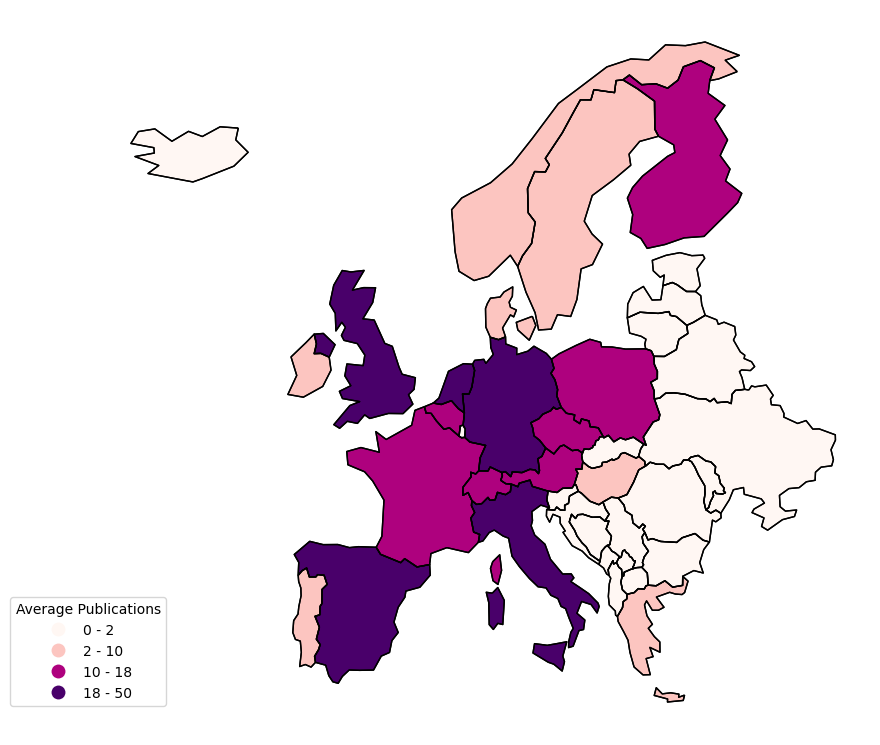

In [209]:
# Plot Map

# Sort in descending order
europe_avgpub_map = europe_avgpub_map.sort_values(by='avg_pub', ascending=False)

# Ensure there are no NaN values
europe_avgpub_map['avg_pub'] = europe_avgpub_map['avg_pub'].fillna(0)

# When generating the bins, the value 0 was not included. This code replaces 0 values with a small positive value before binning
europe_avgpub_map['avg_pub'] = europe_avgpub_map['avg_pub'].replace(0, 0.00001)

# Split df column values into 5 bins
bins = pd.qcut(europe_avgpub_map['avg_pub'], q=5, retbins=True, duplicates='drop',labels=False)[1]
bins[0] = 0  # Ensure the first bin starts at 0
europe_avgpub_map['avg_pub_group'] = pd.cut(europe_avgpub_map['avg_pub'], bins=bins, labels=[f'{int(bins[i])} - {int(bins[i+1])}' for i in range(len(bins)-1)])

# Plot arrangement
fig, ax3 = plt.subplots(figsize=[10, 10])
cmap = plt.cm.get_cmap('RdPu',5) # colour scale
europe_avgpub_map.boundary.plot(ax=ax3, linewidth=1, color='black') # plot country boundaries
europe_avgpub_map.plot(column='avg_pub_group', ax=ax3, legend=True, cmap=cmap, edgecolor='black')

# Customize the legend
legend = ax3.get_legend()
legend.set_bbox_to_anchor((0.1, 0.2))  # Position legend
legend.set_title("Average Publications") # Legend title

# Set map title 
#plt.title('Average Number of Publications by Country', fontsize=16, pad=20)

# Remove axes
ax3.set_axis_off()

# Show plot
plt.show()

In [210]:
# Rate of change from top 10 European countries with most number of publications

# Calculate the rate of change every 2 years - a new df is created using the pivoted table
europe_roc = Count_Europe.pct_change(periods=2) * 100

# Drop the first two rows - 2013 and 2014 - as they have no value assigned
europe_roc = europe_roc.drop([europe_roc.index[0],europe_roc.index[1]])

# Select top 10 European countries with most number of publications
europe_roc = europe_roc[['Austria', 'Belgium', 'France', 'Germany', 'Italy', 'Netherlands', 'Poland', 'Spain', 'Switzerland' ,'United Kingdom']]
europe_roc['Pub_Year'] = europe_roc.index # reset index

# Replace Inf values with NaN
#europe_roc.replace([np.inf, -np.inf], np.nan, inplace=True)

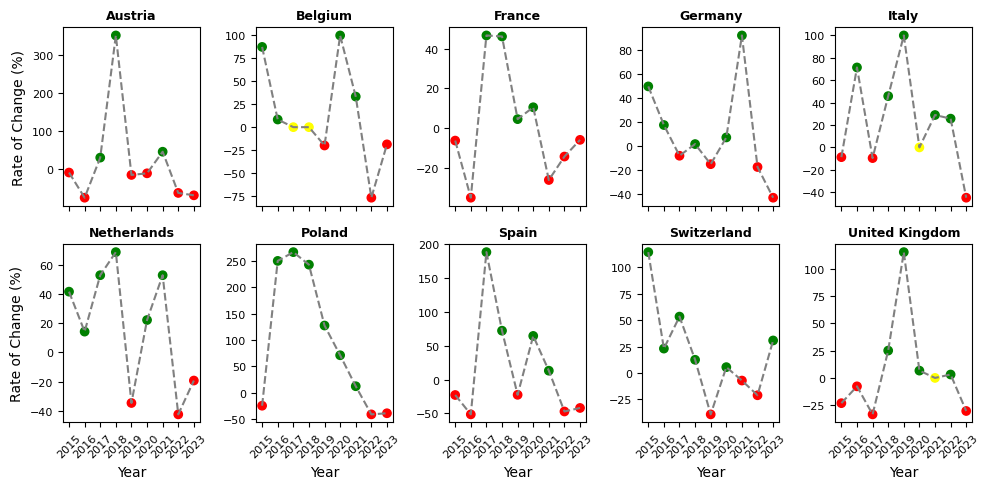

In [211]:
# Extract the list of countries from df
countries = europe_roc.columns.difference(['Pub_Year'])

# Subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# Flatten the axes array
axes = axes.flatten()

# Loop through each country and create the plot
for i,country in enumerate(countries):
    colours = ['green' if val > 0 else 'yellow' if val == 0 else 'red' for val in europe_roc[country]]
    ax = axes[i]
    ax.plot(europe_roc['Pub_Year'], europe_roc[country], linestyle="--", color='gray', label="Rate of Change")
    ax.scatter(europe_roc['Pub_Year'], europe_roc[country], color=colours)
    ax.set_xticks(europe_roc['Pub_Year'])
    ax.set_xticklabels(europe_roc['Pub_Year'], rotation=45, fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_title(country, fontsize=9, weight='bold')
    # ax.set_ylabel('Rate of Change (%)')
    # ax.set_xlabel('Year', fontsize=10)

    # Set y-label only on the leftmost column
    if i % 5 == 0:
        ax.set_ylabel('Rate of Change (%)')
    # else:
    #     ax.set_yticklabels([])

    # Set x-label only on the bottommost row
    if i // 5 == 1:
        ax.set_xlabel('Year', fontsize=10)
    else:
        ax.set_xticklabels([])

# Adjust layout
plt.tight_layout()

##### Q3 - Author Collaborations

In [212]:
# Publications with more that 1 author - Analysis of author collaboration

## Run an SQL query 
dbConnection = ConnectToDatabase()
Year = []
No_authors=[]
if dbConnection is not None:
    SQL_Query_Text = "select Pub_Year, author_count from public.scopusapidata where (author_count > 1) and (author_count < 12) order by Pub_Year asc" # <12 to reduce the number of outliers
    queryResults = sqlQuery(dbConnection,SQL_Query_Text)
    for s in queryResults:
        #print("{}, {}".format(s[0], s[1]))
        Year.append(s[0])
        No_authors.append(s[1])
    #print("\n")
    dbConnection.close()
else:
    print("Failed to connect to the database.")

Connected to database


In [213]:
# Converting SQL query results to df
noauthors_data = {
    'Year': Year,
    'No_authors': No_authors
}

Count_Authors = pd.DataFrame(noauthors_data)

c:\Users\FSzeliga\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\FSzeliga\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\FSzeliga\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


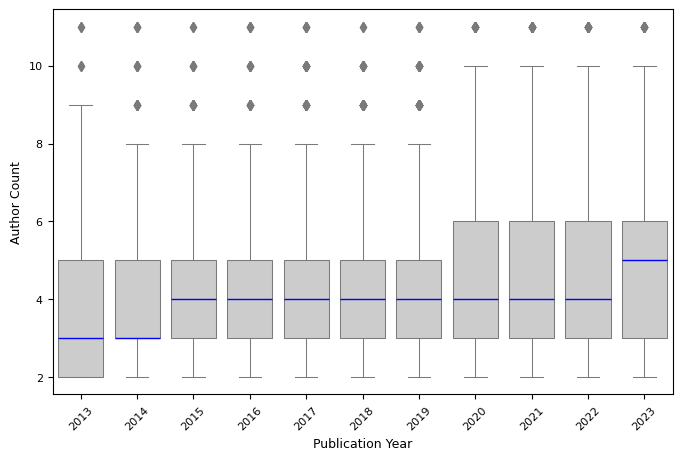

In [214]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Year', y='No_authors', data=Count_Authors, color=".8", medianprops={"color": "b", "linewidth": 1}, linewidth=.75)
plt.xlabel('Publication Year', fontsize=9)
plt.ylabel('Author Count', fontsize=9)
plt.xticks(fontsize=8, rotation=45)  # You can adjust the rotation as needed
plt.yticks(fontsize=8)
#plt.title('Distribution of Author Counts per Publication by Year')
plt.show()

##### Q4: Keywords Analysis

In [22]:
# Keywords 2013 - 2017 

## Run an SQL query 
dbConnection = ConnectToDatabase()
Year = []
Keywords=[]
if dbConnection is not None:
    SQL_Query_Text = "select pub_year,keywords from public.scopusapidata where (pub_year <=2017) and (keywords is not null)"
    queryResults = sqlQuery(dbConnection,SQL_Query_Text)
    for s in queryResults:
        #print("{}, {}".format(s[0], s[1]))
        Year.append(s[0])
        Keywords.append(s[1])
    #print("\n")
    dbConnection.close()
else:
    print("Failed to connect to the database.")

Connected to database


In [23]:
# Converting SQL query results to df
keywords_first5 = {
    'Year': Year,
    'Keywords': Keywords
}

First5_keywords = pd.DataFrame(keywords_first5)

In [24]:
# Keywords 2018 - 2023

## Run an SQL query 
dbConnection = ConnectToDatabase()
Year = []
Keywords=[]
if dbConnection is not None:
    SQL_Query_Text = "select pub_year,keywords from public.scopusapidata where (pub_year >=2018) and (keywords is not null)"
    queryResults = sqlQuery(dbConnection,SQL_Query_Text)
    for s in queryResults:
        #print("{}, {}".format(s[0], s[1]))
        Year.append(s[0])
        Keywords.append(s[1])
    #print("\n")
    dbConnection.close()
else:
    print("Failed to connect to the database.")

Connected to database


In [25]:
# Converting SQL query results to df
keywords_second5 = {
    'Year': Year,
    'Keywords': Keywords
}

Second5_keywords = pd.DataFrame(keywords_second5)

In [28]:
# Combine all keywords into a single list
all_keywords_first5 = []
for keywords in First5_keywords['Keywords']:
    all_keywords_first5.extend(keywords.lower().split(' | ')) # changed keywords to lowercase for consistency


all_keywords_second5 = []
for keywords in Second5_keywords['Keywords']:
    all_keywords_second5.extend(keywords.lower().split(' | ')) # changed keywords to lowercase for consistency

Text(0.5, 1.0, 'Top 50 Keywords (2018-2023)')

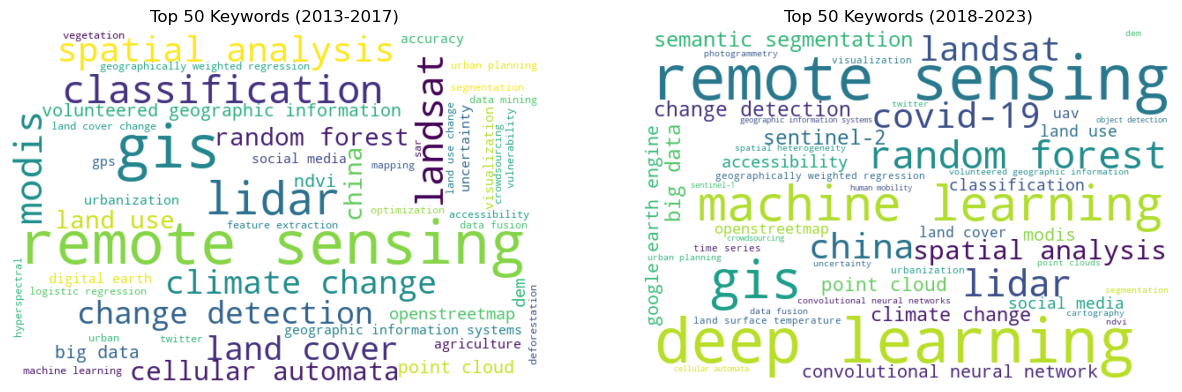

In [29]:
# Count the frequency of each keyword # CHECK FOR REPEATED WORDS!!
keyword_counts_first5 = Counter(all_keywords_first5)
keyword_counts_second5 = Counter(all_keywords_second5)

# Get the top 50 keywords
top_keywords_first5 = keyword_counts_first5.most_common(50)
top_keywords_second5 = keyword_counts_second5.most_common(50)

# Convert to a dictionary for the word cloud
wordcloud_data1 = dict(top_keywords_first5)
wordcloud_data2 = dict(top_keywords_second5)

# Generate the word cloud data
wordcloud1 = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(wordcloud_data1)
wordcloud2 = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(wordcloud_data2)

# Plot wordclouds

fig, (ax4, ax5) = plt.subplots (1,2, figsize=(15,5))

ax4.imshow(wordcloud1, interpolation='bilinear')
ax4.axis('off')
ax4.set_title('Top 50 Keywords (2013-2017)')

ax5.imshow(wordcloud2, interpolation='bilinear')
ax5.axis('off')
ax5.set_title('Top 50 Keywords (2018-2023)')